In [1]:
from qiskit import QuantumCircuit, transpile, BasicAer, QuantumRegister, execute, ClassicalRegister
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
from qiskit.circuit.library.standard_gates import RXGate, RZGate
from qiskit.extensions.unitary import UnitaryGate
from qiskit.visualization import plot_histogram

# Grover's Search Algorithm
Task:
- Find a particular element in an unordered array of m elements.
- Classically, $\mathcal{O}(m)$ queries
- Quantum, $\mathcal{\sqrt{m}}$ queries

Given some unitary matrix $U_f$ that takes $|\textbf{x},y\rangle$ to $|\textbf{x},f(\textbf{x}) \oplus y\rangle$, where $f(x)=1$ if $x=x_0$, else $f(x)=0$.

Naively, we input $|x\rangle$ as a superposition of all possible strings, then evaluate it on $U_f$. However, we only measure the correct answer with probability $\frac{1}{2^n}$.

Employ two tricks: (a) phase inversion, (b) inversion about the mean.

#### Phase Inversion
Place the ancilla qubit (y) in superposition, (assume y is initially $|1\rangle$)

\begin{equation*}
|\psi_1\rangle = \left[\frac{|x,0\rangle - |x,1\rangle}{\sqrt{2}}\right]
\end{equation*}

Then 
\begin{equation*}
|\psi_2\rangle = U_f|\psi_1\rangle = |x\rangle \left[\frac{|f(x) \oplus 0 \rangle - |f(x) \oplus 1\rangle}{\sqrt{2}} \right] = |x\rangle \left[\frac{|f(x)\rangle - |\overline{f(x)}\rangle}{\sqrt{2}} \right]
\end{equation*}

Rewritten as

\begin{equation*}
|\psi_2\rangle = 
\begin{cases}
    -1|x\rangle \left[\frac{|0\rangle - |1\rangle}{\sqrt{2}}\right] & \text{if } x = x_0 \\
    +1|x\rangle \left[\frac{|0\rangle - |1\rangle}{\sqrt{2}}\right] & \text{if } x \neq x_0 \\
\end{cases}
\end{equation*}

#### Inversion about the mean
Need a way of boosting the phase separation of the target string from the others. 
Inversion about the mean, mathematically $v' = -v + 2a$, for all elements $v$, and mean $a$.

To find mean using matrices, use
\begin{equation*}
A = 
\begin{bmatrix}
\frac{1}{2^n} & \frac{1}{2^n} & \ldots & \frac{1}{2^n}\\
\frac{1}{2^n} & \frac{1}{2^n} & \ldots & \frac{1}{2^n}\\
\vdots & \vdots & \ddots & \vdots\\
\frac{1}{2^n} & \frac{1}{2^n} & \ldots & \frac{1}{2^n}\\
\end{bmatrix}
\end{equation*}

Multiplying any state by $A$ will give a state where ach amplitude will be the average of all the amplitudes. 

\begin{equation*}
-I + 2A = 
\begin{bmatrix}
-1 + \frac{2}{2^n} & \frac{2}{2^n} & \ldots & \frac{2}{2^n}\\
\frac{2}{2^n} & -1+\frac{2}{2^n} & \ldots & \frac{2}{2^n}\\
\vdots & \vdots & \ddots & \vdots\\
\frac{2}{2^n} & \frac{2}{2^n} & \ldots & -1+\frac{2}{2^n}\\
\end{bmatrix}
\end{equation*}

Multiplying a state by $-I+2A$ will invert amplitudes about the mean.

#### Putting it together
A Grover iteration consistents a both phase inversion and inversion about mean, the operation separates the amplitude of the desired state from those of all the other states. If repeated $\sqrt{2^n}$ times, then is sufficient for finding desired state on measurement. Qiskit and N&C use a slightly different convention for their oracle functions that mark states with a negative phase, rather than a binary function. The benefit of using this oracle convention is that the "diffuser" (amplification) doesn't need to use ancilla "oracle workspace" qubits.

In [217]:
"""Choosing to mark that states |110> and |101>"""
qc = QuantumCircuit(3)
qc.cz(0, 2)
qc.cz(1, 2)
oracle_ex3 = qc.to_gate()
oracle_ex3.name = "U$_\omega$"
# print(Operator(oracle_ex3).data)

In [204]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

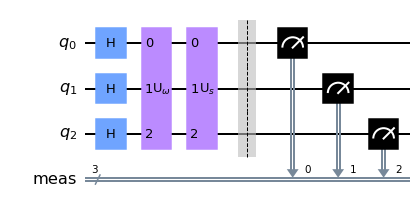

In [205]:
n = 3
grover_circuit = QuantumCircuit(n)
for q in range(n):
    grover_circuit.h(q)
grover_circuit.append(oracle_ex3, [0,1,2])
grover_circuit.append(diffuser(n), [0,1,2])
grover_circuit.measure_all()
grover_circuit.draw(output='mpl')

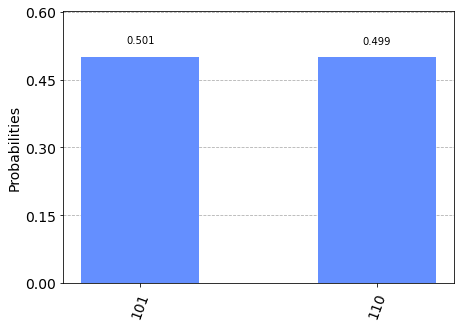

In [206]:
backend = BasicAer.get_backend('qasm_simulator')
job = execute(grover_circuit, backend)
plot_histogram(job.result().get_counts())

# Quantum Signal Processing (QSP)
Intuition: 
- Observe non-unitary dynamics on a subsystem of qubits to realize non-reversible and non-linear functions
- QSP is a framework for building polynomial functions of degree d out of $\mathcal{O}(d)$ unitary operations

Goal: Quantum Singular Value Transform (QSVT) generalizes QSP, build a polynomial function that describes subroutines of Grover's Search, Phase Estimation, Hamiltonian Simulation. -> Grand Unification!

Want to look at an example problem that is simplified by looking at qubit-like subsystems.

*Key concept*: Qubitization:  use the
controlled version of  oracles to embed any $\hat{H}$ in an invariant SU(2) subspace
https://arxiv.org/pdf/1610.06546v3.pdf

*The key idea of QSVT comes from the use of block-encoded operators, and their constructions. In this first version of notes I don't go into this in detail. Section II.E of paper goes into motivation and details. The starting place of QSVT algorithms will be finding a desired operator, A, to be encoded as a block inside a larger unitary matrix, U. When A is a unitary matrix, then U becomes a controlled-A operator.

#### Define QSP composite pulse sequence
1. Signal Operator $W$
2. Phase angles, $\vec{\phi} = (\phi_1, \phi_2, \ldots, \phi3)$
3. Signal Processing Operator $S(\phi)$, using $\phi \in \vec{\phi}$
4. The Signal Basis M

The $W_x$ convention, $(W_x, S_z, \langle + | \cdot | + \rangle$)-QSP


In [194]:
def W(a):
    return RXGate(theta  = -2* np.arccos(a))
    #return UnitaryGate([[a, 1j*np.sqrt(1-(a**2))],[1j*np.sqrt(1-(a**2)), a]])
   
def S(phi_i):
    return RZGate(phi = -2*phi_i)

Composite pulse sequences interleave two kinds of single qubit rotations: a signal rotation operator $W$, and a signal processing rotation operator $S$.

\begin{equation*}
W(a) = 
\begin{bmatrix}
a& i\sqrt{1-a^2}\\
i\sqrt{1-a^2}& a
\end{bmatrix}, \quad S(\phi) = e^{i \phi Z}
\end{equation*}

\begin{equation*}
U_{\vec{\phi}} = e^{i \phi_0 Z} \prod_{k=1}^{d} W(a) e^{i \phi_k Z}
\end{equation*}

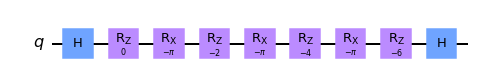

In [195]:
def qsp(a, phi_vec, basis='+'):
    assert basis in ['+', '0']
    d = len(phi_vec)
    qc = QuantumCircuit(1)
    if basis =='+':
        qc.h(0) #state prep |+>
    qc.append(S(phi_vec[0]), [0])
    for i in range(1,d):
        qc.append(W(a), [0])
        qc.append(S(phi_vec[i]), [0])
    if basis =='+':
        qc.h(0) #measure in |+> basis
    return qc

#parameterized differently to construct plot from paper
def qsp_theta(theta, phi_vec):
    d = len(phi_vec)
    qc = QuantumCircuit(1)
    qc.append(S(phi_vec[0]), [0])
    for i in range(1,d):
        qc.append(RXGate(theta=theta), [0])
        qc.append(S(phi_vec[i]), [0])
    return qc

#example
phi_vec = [0,1,2,3]
qc = qsp(0, phi_vec=phi_vec)
qc.draw(output='mpl')

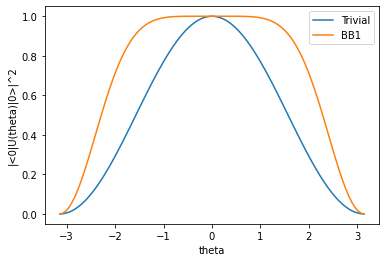

In [196]:
#make a plot to show how QSP can modify the incoming signal
backend = BasicAer.get_backend('statevector_simulator')
theta_range = np.linspace(-np.pi, np.pi, num=100)

phi_vec = [0,0]
p1_data = []
for t_i in theta_range:
    qc = qsp_theta(t_i, phi_vec=phi_vec)
    result = backend.run(transpile(qc, backend)).result()
    output_state = result.get_statevector(qc)
    p = np.abs(output_state[0])**2
    p1_data.append(p)

eta = (1/2) * np.arccos(-1/4)
phi_vec = [np.pi/2, -eta, 2*eta, 0, -2*eta, eta]
p2_data = []
for t_i in theta_range:
    qc = qsp_theta(t_i, phi_vec=phi_vec)
    result = backend.run(transpile(qc, backend)).result()
    output_state = result.get_statevector(qc)
    p = np.abs(output_state[0])**2
    p2_data.append(p)

plt.plot(theta_range, p1_data, label="Trivial")
plt.plot(theta_range, p2_data, label="BB1")
plt.xlabel("theta")
plt.ylabel("|<0|U(theta)|0>|^2")
plt.legend()
plt.show()

This QSP has nice property that the qubit remains unflipped for a wide range of signal angles, then with sharp transition around $\theta = \approx 2 \pi/3$. For this reason, BB1 is a famous sequence from NMR used to increase image constrast.

**Many sequences are known and are used to suppress specific kinds of errors and enhance sensitvity to specific kinds of signals.**

In general, the matrix element $P(a) = \langle 0 | U_{\vec{\phi}} | 0 \rangle$ becomes a polynomial in a, with the order of the polynomial being at most the length of the sequence of QSP phases $\vec{\phi}$.

For example,the Chebyshev polynomials $T_d(a)$
- $\vec{\phi} = (0,0), P(a) = a$
- $\vec{\phi} = (0,0,0), P(a) = 2a^2 -1$
- $\vec{\phi} = (0,0,0), P(a) = 4a^3-3a$

/home/evm9/decomposition_EM/decomp_venv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


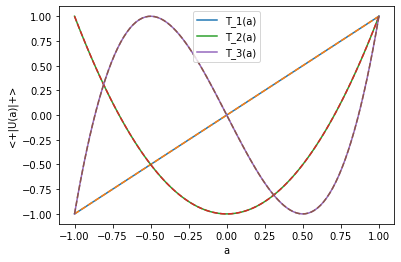

In [197]:
#make a plot to show how QSP can modify the incoming signal
backend = BasicAer.get_backend('statevector_simulator')
a_range = np.linspace(-1,1, num=100)

phi_vec = [0,0]
p1_data = []
p1_target = []
for a_i in a_range:
    qc = qsp(a_i, phi_vec=phi_vec)
    result = backend.run(transpile(qc, backend)).result()
    output_state = result.get_statevector(qc)
    p = output_state[0]
    p1_data.append(p)
    p1_target.append(a_i)

phi_vec = [0,0,0]
p2_data = []
p2_target = []
for a_i in a_range:
    qc = qsp(a_i, phi_vec=phi_vec)
    result = backend.run(transpile(qc, backend)).result()
    output_state = result.get_statevector(qc)
    p = output_state[0]
    p2_data.append(p)
    p2_target.append(2*(a_i**2) -1)

phi_vec = [0,0,0,0]
p3_data = []
p3_target = []
for a_i in a_range:
    qc = qsp(a_i, phi_vec=phi_vec)
    result = backend.run(transpile(qc, backend)).result()
    output_state = result.get_statevector(qc)
    p = output_state[0]
    p3_data.append(p)
    p3_target.append(4*(a_i**3) - 3*a_i)

plt.plot(a_range, p1_data, label="T_1(a)")
plt.plot(a_range, p1_target, '--')
plt.plot(a_range, p2_data, label="T_2(a)")
plt.plot(a_range, p2_target, '--')
plt.plot(a_range, p3_data, label="T_3(a)")
plt.plot(a_range, p3_target, '--')
plt.xlabel("a")
plt.ylabel("<+|U(a)|+>")
plt.legend()
plt.show()

The remarkable property of the QSP sequence is the reverse also holds; *for a given polynomial $P(a)$, there exists a set of QSP phase angles $\vec{\phi}$ such that $P(a) = \langle 0 | U_{\vec{\phi}} | 0 \rangle$*

**Quantum Signal Processing Theorem**
The QSP sequence produces a matrix which may be expressed as a poynomial function of a:
\begin{equation*}
e^{i \phi_0 Z} \prod_{k=1}^{d} W(a) e^{i \phi_k Z} = \begin{bmatrix}P(a) & i Q(a) \sqrt{1-a^2}\\ i Q^*(a)\sqrt{1-a^2} & P^*(a)\end{bmatrix}
\end{equation*}
for $a\in[-1,1]$, and a $\vec{\phi}$ exists for any polynomials $P,Q$ in $a$ such that

1. $\deg(P) \leq d, \deg(Q) \leq d-1$
2. $P$ has parity $d\mod 2$ and $Q$ has parity $(d-1)\mod 2$
3. $|P|^2 + (1-a^2)|Q|^2 = 1$.

We are interested in the the achievable polynomial transformations of the input Poly(a), in a subsystem. We overcome expressive limitations by defining $Poly(a) = \langle + | U_{\vec{\phi}} | + \rangle = Re(P(a)) + i Re(Q(a))\sqrt{1-a^2}$. It can be shown that we can accurately approximate any real polynomial with party $d\mod2$ such that $\deg(Poly) \leq d$, and $|Poly(a)| \leq 1 \forall a \in [-1,1]$.

QSP Theorem guarantees the existence of such a $\vec{\phi}$, it does not provide a method for determining it. There are a handful of exchange algorithms, numerical optimizations, known solutions for a family of polynomials, etc. that are given in Appendix D. The code for generating phase angles is available in the pyqsp repo https://github.com/ichuang/pyqsp.


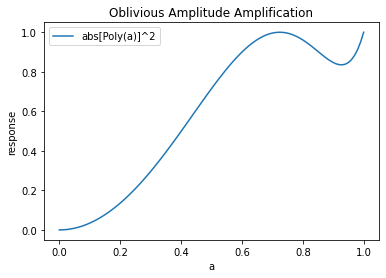

In [198]:
#make a plot to show how QSP example of Oblivious Amplitude Amplification
from scipy.special import erf
backend = BasicAer.get_backend('statevector_simulator')
a_range = np.linspace(0,1, num=100)

phi_vec = [-1.58023603,-1.55147987,-1.6009483,-1.52812171,-1.62884337,-1.49242141,-1.67885248,-1.41255145,-1.8386054,-0.87463828,-0.87463828,-1.8386054,-1.41255145,-1.67885248,-1.49242141,-1.62884337,-1.52812171,-1.6009483,-1.55147987,-1.58023603]
p1_data = []
p1_target = []
for a_i in a_range:
    #paper says should be |+> basis but I don't agree
    qc = qsp(a_i, phi_vec=phi_vec, basis='0')
    result = backend.run(transpile(qc, backend)).result()
    output_state = result.get_statevector(qc)
    p = output_state[0]
    p1_data.append((np.abs(p))**2)
    p1_target.append(erf(10*a_i))

plt.plot(a_range, p1_data, label="abs[Poly(a)]^2")
# plt.plot(a_range, p1_target, '--')
plt.xlabel("a")
plt.ylabel("response")
plt.legend()
plt.title("Oblivious Amplitude Amplification")
plt.show()

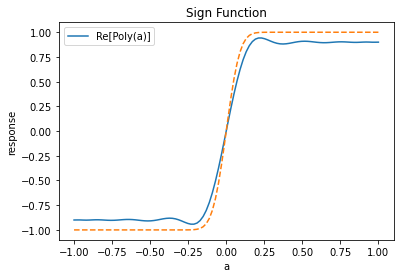

In [199]:
#make a plot to show how QSP example of Sign Function
from scipy.special import erf
backend = BasicAer.get_backend('statevector_simulator')
k=10
a_range = np.linspace(-1,1, num=100)

phi_vec = [0.01558127,-0.01805798,0.05705643,-0.01661832,0.16163773,0.09379074,-2.62342885,0.49168481,0.92403822,-0.09696846,-0.09696846,0.92403822,0.49168481,-2.62342885,0.09379074,0.16163773,-0.01661832,0.05705643,-0.01805798,1.5863776]
p1_data = []
p1_target = []
for a_i in a_range:
    qc = qsp(a_i, phi_vec=phi_vec)
    result = backend.run(transpile(qc, backend)).result()
    output_state = result.get_statevector(qc)
    p = output_state[0]
    p1_data.append(np.real(p))
    p1_target.append(erf(k*a_i))

plt.plot(a_range, p1_data, label="Re[Poly(a)]")
plt.plot(a_range, p1_target, '--')
plt.xlabel("a")
plt.ylabel("response")
plt.legend()
plt.title("Sign Function")
plt.show()

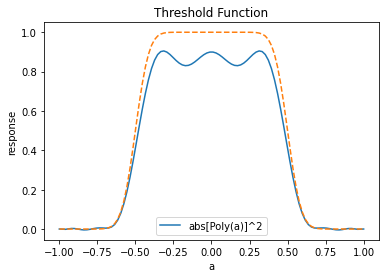

In [200]:
#make a plot to show how QSP example of Threshold Function
from scipy.special import erf
backend = BasicAer.get_backend('statevector_simulator')
k=10
a_range = np.linspace(-1,1, num=100)

phi_vec = [0.73930816,-0.69010006,-0.63972139,-0.47754554,0.81797049,0.09205065,-0.87660105,0.13460844,0.23892207,1.32216648,-2.90267058,0.13460844,2.2649916,0.09205065,-2.32362216,2.66404712,-0.63972139,-0.69010006,2.31010449]
p1_data = []
p1_target = []
for a_i in a_range:
    qc = qsp(a_i, phi_vec=phi_vec)
    result = backend.run(transpile(qc, backend)).result()
    output_state = result.get_statevector(qc)
    p = output_state[0]
    p1_data.append((np.real(p)))
    p1_target.append(.5*(erf(k*(a_i+.5)) - erf(k*(a_i-.5))))
    

plt.plot(a_range, p1_data, label="abs[Poly(a)]^2")
plt.plot(a_range, p1_target, '--')
plt.xlabel("a")
plt.ylabel("response")
plt.legend()
plt.title("Threshold Function")
plt.show()

#### Application to Amplitude Amplification and Search
In general, the problem of amplitude amplification, is to construct a circuit $Q$ using $U, U^{\dagger}, A_\phi, B_\phi$ such that $|\langle A_0 | Q | B_0 \rangle \to 1$, assuming $\langle A_0 | U | B_0 \rangle \neq 0 $.

Idea: look at qubit-like subspace to derive the oblivious fixed-point amplitude amplification algorithm.

First, using assumption, we know the state $U|B_0\rangle$ can be described by its components along $|A_0\rangle$ and a perpendicular component $|A_\perp\rangle$. It can be shown for $a=\langle A_0 | U | B_0 \rangle$,

\begin{equation*}
U|B_0\rangle = a |A_0\rangle + \sqrt{1-a^2}|A_\perp\rangle
\end{equation*}

Despite $U$ being of an arbitrarily large dimension, the action can be written as a $2 \times 2$ unitary:

\begin{equation*}
U = a (|A_0\rangle \langle B_0| - |A_\perp\rangle \langle B_\perp |) + \sqrt{1-a^2}(|A_\perp\rangle \langle B_0| + |A_0\rangle \langle B_\perp |)
\end{equation*}

which is written in matrix form as (I can't write full notation in markdown)

\begin{equation*}
U=R(a)=
\begin{bmatrix}
a & \sqrt{1-a^2}\\
\sqrt{1-a^2} & -a
\end{bmatrix}
\end{equation*}
where columns act on $|B_0\rangle, |B_\perp \rangle$ and rows act on $|A_0\rangle, |A_\perp \rangle$, such that $U$ brings a state in the B basis in to a state in the A basis.


**Amplitude Amplification Theorem**
Given a unitary $U$, its inverse, and operators $A_\phi = e^{i \phi |A_0\rangle \langle A_0|}, B_\phi = e^{i \phi |B_0\rangle \langle B_0|}$
\begin{equation*}
\langle A_0 | A_{\phi_0} \left[\prod_{k=1}^{\frac{d-1}{2}} U B_{\phi_{2k-1}} U^\dagger A_{\phi_{2k}}\right] U |B_0\rangle = Poly(a)
\end{equation*}
where d is odd, and Poly(a) is a polynomial in $a=\langle A_0 | U | B_0 \rangle$ of degree at most d that obeys the conditions on P from the QSP Theorem.

*What is going on here??* The sequence of operations maps the state back and forth between the two qubit bases, sandwiching y-axis rotations with z-axis rotations. This sandwich of rotations is thus just doing QSP!

To make this even more recognizable to the previous form, 
\begin{equation*}
R(a) = -ie^{i\frac{\pi}{4} Z} W(a) e^{i \frac{\pi}{4} Z}
\end{equation*}
and treat $A_\phi, B_\phi$ as simply x-axis rotations

\begin{equation*}
\langle A_0 | \left( e^{i\phi'_0 Z}\left[\prod_{k=1}^{d} W(a) e^{i\phi'_k Z} \right] \right) U |B_0\rangle = Poly(a)
\end{equation*}

Considered "oblivious amplitude amplification" when the phases ${\phi_k}$ are chosen such that the polynomial constructed approximates the sign function for small values of a.

#### Deriving Grover's
In the search problem, some basis state $|A_0\rangle$ is unknown, but an oracle is given that implements $A_\pi = e^{i \pi |A_0\rangle \langle A_0|}$, and the goal is to create a quantum state close to $|A_0\rangle$ using few queries to the oracle.

Choose $U = H^{\otimes n}$ and $|B_0\rangle = |0\rangle$. Note that $a= 1/\sqrt{N}$ because $U|B_0\rangle = |\psi_0\rangle$ is in an equal superposition over all N basis states in the search space. Choose $\phi_k = \pi$ for all $k$.

\begin{equation*}
U B_\phi U^\dagger = e^{i \pi H^{\otimes n} |0\rangle \langle 0 | H^{\otimes n}} = I = 2|\psi_0\rangle \langle \psi_0|
\end{equation*}
*which we recognize as Grover's iversion about the mean step!*

[There is also a discussion about using the oscillating polynomial to derive the query complexity]

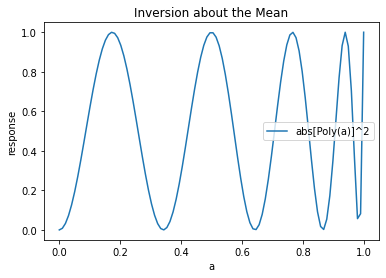

In [221]:
#make a plot to show how QSP example of Oblivious Amplitude Amplification
from scipy.special import erf
backend = BasicAer.get_backend('statevector_simulator')
a_range = np.linspace(0,1, num=100)

phi_vec = [np.pi for _ in range(k)]
p1_data = []
p1_target = []
for a_i in a_range:
    #paper says should be |+> basis but I don't agree
    qc = qsp(a_i, phi_vec=phi_vec, basis='0')
    result = backend.run(transpile(qc, backend)).result()
    output_state = result.get_statevector(qc)
    p = output_state[0]
    p1_data.append((np.abs(p))**2)
    p1_target.append(erf(10*a_i))

plt.plot(a_range, p1_data, label="abs[Poly(a)]^2")
# plt.plot(a_range, p1_target, '--')
plt.xlabel("a")
plt.ylabel("response")
plt.legend()
plt.title("Inversion about the Mean")
plt.show()

### Search by QSVT

Convention of Grover's is to begin with uniform superposition, written w.r.t to the flagged state $|m\rangle$
\begin{equation*}
|\psi_0\rangle = \frac{1}{\sqrt{n}} \sum_j^N |j\rangle = \sqrt{\frac{N-1}{N}} |m^\perp \rangle + \frac{1}{\sqrt{N}} |m\rangle
\end{equation*}

Instead of thinking about constructing Grover iterations, rephrase the problem. We are given some initial state $|\psi_0\rangle$ such that its projection, denoted $\Pi$, onto the desired final state $|m\rangle$ is nonzero. $\Pi V |\psi_0\rangle = a |m\rangle$.

Note: I'm starting to get lost in the details here...

Restating the problem: We desire a circuit $U'$ such that 
\begin{equation*}
\Big|\Big| |m\rangle \langle m| U' |\psi_0 \rangle \langle \psi_0 | - |m\rangle \langle |\psi_0| \Big|\Big| < \epsilon
\end{equation*}
for some small $\epsilon > 0$.

Creating a block encoding, refer to $|\psi_0\rangle \langle \psi_0|$ as $\Pi'$.
\begin{equation*}
\Pi V \Pi' = \Pi \Pi' = a|m\rangle \langle \psi_0|
\end{equation*}

The QSVT theorem states some requirements for, given a block encoding of a matrix $A$, the conditions which define a polynomial transformation to the singular values of $A$. The relevant singular value in this case is $a$, which we want to map to 1 given our problem statement. Therefore, the QSVT polynomial we choose is $\text{erf}{(k[x-c])}$ to approximate the sign function $\Theta(x-c)$.


Next, we need to use a scheme to apply the polynomially approximate sign function to the inital uniform superposition state. [Another discussion here about query complexity, i.e. choice of approximation constants so the probability of measuring the flagged state is sufficient]

![Block-Encoding](/home/evm9/decomposition_EM/images/block-encodings.PNG)